#      1.   Preprocessing


  ## 1.1.   Importing Libraries

In [0]:
import cv2
import matplotlib.pyplot  as plt
import numpy              as np
import pandas             as pd
from sklearn              import svm
from sklearn              import metrics
from sklearn.metrics      import accuracy_score
from skimage              import feature

%matplotlib inline

## 1.2.   Mounting Google Drive


In [20]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [21]:
cd /content/gdrive/My\ Drive/a1

/content/gdrive/My Drive/a1


In [22]:
ls

13326487_Krut_A1_ANN.ipynb  t10k-images-idx3-ubyte.gz
13326487_Krut_A1.ipynb      t10k-labels-idx1-ubyte.gz
13326487_Krut_A1_KNN.ipynb  train-images-idx3-ubyte.gz
13326487_Krut_A1_SVM.ipynb  train-labels-idx1-ubyte.gz
DNN_A1.ipynb




## 1.3.   Dataset Preparation




In [0]:
#defining the loading function
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte.gz'% kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte.gz'% kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

In [0]:
#Importing data into variables
x_train, y_train = load_mnist('/content/gdrive/My Drive/a1', kind='train')
x_test, y_test = load_mnist('/content/gdrive/My Drive/a1', kind='t10k')
# initialize the label names

labelNames = ["0", "1", "2","3", "4", "5", "6", "7", "8", "9"]

In [25]:
#checking Dimentions of x_train
np.shape(x_train)

(60000, 784)

In [0]:
#converting vector data into Pixels
p_x_train = x_train.reshape(-1,28,28)
p_x_test = x_test.reshape(-1,28,28)

In [0]:
#Normalizing Data
n_x_train = x_train / 255
n_x_test = x_test / 255

In [0]:
# Reshaping Normalized data
r_x_train = n_x_train.reshape(-1,28,28)
r_x_test = n_x_test.reshape(-1,28,28)

In [29]:
#checking Dimentions of x_train
np.shape(r_x_train)

(60000, 28, 28)



## 1.4.   Image Plotting (Visualization)



In [0]:
#storing image from each class
int_labels =np.asarray(labelNames, dtype=np.int)
class_img = []

for i in range(0,10):
  train_list = list(y_train)
  inter = train_list.index(int_labels[i])
  class_img.append(inter)

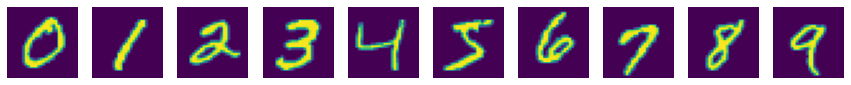

In [31]:
#plotting image of each class
fig = plt.figure(figsize=(15,15))
for i in range (1,11):
  fig.add_subplot(1,10,i)
  plt.imshow(p_x_train[class_img[i-1]])
  plt.axis('off')

plt.show()



# 2.   Feature Extraction




## 2.1.   HoG




In [32]:
# Extracting HoG feature from training dataset
h_x_train = []
h_y_train = []

#Extracting feature from one image at a time
for i in range(len(r_x_train)):
  img = (r_x_train[i])
  hog = feature.hog(img, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
  h_x_train.append(hog)
  h_y_train.append(y_train[i])



print(np.shape(h_x_train))
print(np.shape(h_y_train))

(60000, 36)
(60000,)


In [33]:
# Extracting HoG feature from testing dataset
h_x_test = []
h_y_test = []

for i in range(len(r_x_test)):
  hog_img = (r_x_test[i])
  hog = feature.hog(hog_img, orientations=9, pixels_per_cell=(10,10), cells_per_block=(2,2), transform_sqrt=True, block_norm="L2-Hys")

  h_x_test.append(hog)
  h_y_test.append(y_test[i])


print(np.shape(h_x_test))
print(np.shape(h_y_test))
print(h_y_test[0])

(10000, 36)
(10000,)
7




## 2.2.   LBP



In [0]:
#defining LBP
class LocalBinaryPatterns:
  #initializing function
	def __init__(self, numPoints, radius):
		self.numPoints = numPoints
		self.radius = radius
 
 #function to extract LBP feature
	def LBPfeatures(self, image, eps=1e-7):
		lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
    #converting it to histogram
		(hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints + 3), range=(0, self.numPoints + 2))
 
		# normalize the histogram
		hist = hist.astype("float")
		hist /= (hist.sum() + eps)
 
		return hist

In [35]:
# Creating object and extracting LBP feature from training data
lbp_obj = LocalBinaryPatterns(24, 8)
l_x_train = []
l_y_train = []

# Processing one Image at a time
for i in range(len(r_x_train)):
	lbp_img = (r_x_train[i])
	lbp_hist = lbp_obj.LBPfeatures(lbp_img)
	l_x_train.append(lbp_hist)
	l_y_train.append(y_train[i])
 

print(np.shape(l_x_train))
print(np.shape(l_y_train))

(60000, 26)
(60000,)


In [36]:
# Creating object and extracting LBP feature from testing data
lbp_obj = LocalBinaryPatterns(24, 8)
l_x_test = []
l_y_test = []

# Processing one Image at a time
for i in range(len(r_x_test)):
	lbp_img = (r_x_test[i])
	lbp_hist = lbp_obj.LBPfeatures(lbp_img)
	l_x_test.append(lbp_hist)
	l_y_test.append(y_test[i])
 

print(np.shape(l_x_test))
print(np.shape(l_y_test))

(10000, 26)
(10000,)



#3.   SVM






## 3.1.   Training and evaluating SVM with LBP



In [37]:
#creating SVM model and Fitting Training Data into it
lbp_svm = svm.SVC(kernel='rbf', C=100.0, random_state=42)
lbp_svm.fit(l_x_train, l_y_train)


SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [38]:
# Check the training accuray
print("Train set Accuracy: {:.2f}".format(lbp_svm.score(l_x_train,l_y_train)))

Train set Accuracy: 0.51


In [0]:
# Predicting lables of testing set 
lbp_svm_pred = lbp_svm.predict(l_x_test)

In [40]:
#measuring training accuracy
lbp_svm_acc = metrics.accuracy_score(y_test, lbp_svm_pred)
print("Accuracy on test dataset:",lbp_svm_acc)

Accuracy on test dataset: 0.5211


In [41]:
# plot the confusion matrix
print("Y axis represents the actual label with 0 as lower and 9 as upper")
print("X axis represents the predicted label with 0 as leftmost and 9 as rightmost")
cm  = metrics.confusion_matrix(l_y_test, lbp_svm_pred)
print(cm)

Y axis represents the actual label with 0 as lower and 9 as upper
X axis represents the predicted label with 0 as leftmost and 9 as rightmost
[[ 918    0   11    4    1   25    0    3    3   15]
 [   0 1091    3    0    3    1    1   29    7    0]
 [  21    1  502   86   47   72   50  144   88   21]
 [  31   16  155  274   91  113   35  130  105   60]
 [   7    3  105   23  387   23   46   70   66  252]
 [ 102    9   94   94   84  211   30  162   40   66]
 [  56   14  182   61   58   69  140  115  138  125]
 [  14   56   68   16   67   49   23  685   23   27]
 [  33    3   54   94   71   20   60   31  528   80]
 [  49   14   15   38  204   39   58   51   66  475]]


In [0]:
# Display the some classification result on test samples
lbp_svm_img = []
lbp_svm_lbl = []
 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
  histog = (l_x_test[i])
  prediction = lbp_svm.predict(histog.reshape(1, -1))[0]
  image = r_x_test[i]
  lbp_svm_img.append(image)
  lbp_svm_lbl.append(prediction)

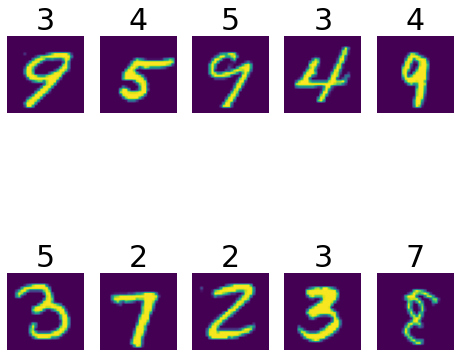

In [43]:
#plotting random predicted outputs
fig = plt.figure(figsize=(8,8))
for i in range (1,11):
  fig.add_subplot(2,5,i)
  plt.title(lbp_svm_lbl[i-1], size= 30)
  plt.imshow(lbp_svm_img[i-1])
  plt.axis('off')

plt.show()



## 3.2.   Training and evaluating SVM with HoG




In [44]:
#creating SVM model and Fitting Training Data into it
hog_svm = svm.SVC(kernel='rbf', C=100.0, random_state=42)
hog_svm.fit(h_x_train, h_y_train)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [45]:
# Check the training accuray
print("Train set Accuracy: {:.2f}".format(hog_svm.score(h_x_train,h_y_train)))

Train set Accuracy: 0.99


In [0]:
# Predicting lables of testing set 
hog_svm_pred = hog_svm.predict(h_x_test)

In [47]:
#measuring testing accuracy
hog_svm_acc = metrics.accuracy_score(y_test, hog_svm_pred)
print("Accuracy on test dataset:",hog_svm_acc)

Accuracy on test dataset: 0.9098


In [48]:
# plot the confusion matrix
print("Y axis represents the actual label with 0 as lower and 9 as upper")
print("X axis represents the predicted label with 0 as leftmost and 9 as rightmost")
cm  = metrics.confusion_matrix(h_y_test, hog_svm_pred)
print(cm)

Y axis represents the actual label with 0 as lower and 9 as upper
X axis represents the predicted label with 0 as leftmost and 9 as rightmost
[[ 924    5    5    1    2    3   20    0   15    5]
 [   6 1118    3    2    0    0    4    1    1    0]
 [   7    3  922   39    3    1    1   34   19    3]
 [   2    2   40  890    1   28    0   19   23    5]
 [   3    3    6    1  917    1   35    4    5    7]
 [   5    1    6   31    4  805    9    4   18    9]
 [  19    2    3    0   31   10  883    0    7    3]
 [   2    8   40   33    1    5    0  926    3   10]
 [  35    1   20   32    7   20   15    1  806   37]
 [  13    7    5   12   12   14    2   12   25  907]]


In [0]:
# Display the some classification result on test samples
hog_svm_img = []
hog_svm_lbl = []

 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
  histog = (h_x_test[i])
  prediction = hog_svm.predict(histog.reshape(1, -1))[0]
  image = r_x_test[i]
  hog_svm_img.append(image)
  hog_svm_lbl.append(prediction)

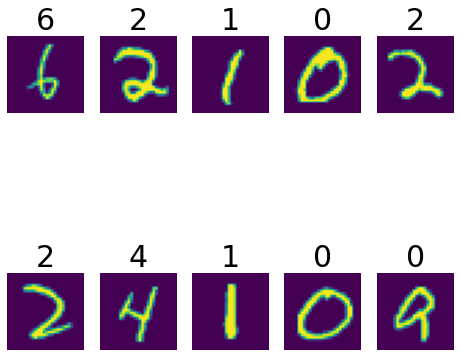

In [50]:
#plotting random predicted outputs
fig = plt.figure(figsize=(8,8))
for i in range (1,11):
  fig.add_subplot(2,5,i)
  plt.title(hog_svm_lbl[i-1], size= 30)
  plt.imshow(hog_svm_img[i-1])
  plt.axis('off')

plt.show()



##3.3.   Training and evaluating SVM with Raw Data



In [51]:
#checking Input shape
np.shape(r_x_train)

(60000, 28, 28)

In [52]:
#checking output shape
np.shape(y_train)

(60000,)

In [53]:
#creating SVM model and Fitting Training Data into it
raw_svm = svm.SVC(kernel='rbf', C=100.0, random_state=42)
raw_svm.fit(n_x_train, y_train)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [54]:
# Check the training accuray
print("Train set Accuracy: {:.2f}".format(raw_svm.score(n_x_train,y_train)))

Train set Accuracy: 1.00


In [0]:
# Predicting lables of testing set 
raw_svm_pred = raw_svm.predict(n_x_test)

In [56]:
#measuring testing accuracy
raw_svm_acc = metrics.accuracy_score(y_test, raw_svm_pred)
print("Accuracy on test dataset:",raw_svm_acc)

Accuracy on test dataset: 0.9833


In [57]:
# plot the confusion matrix
print("Y axis represents the actual label with 0 as lower and 9 as upper")
print("X axis represents the predicted label with 0 as leftmost and 9 as rightmost")
cm  = metrics.confusion_matrix(y_test, raw_svm_pred)
print(cm)

Y axis represents the actual label with 0 as lower and 9 as upper
X axis represents the predicted label with 0 as leftmost and 9 as rightmost
[[ 973    0    2    0    0    2    0    1    2    0]
 [   0 1129    2    1    0    1    0    1    1    0]
 [   5    1 1014    0    1    0    1    6    4    0]
 [   0    0    2  995    0    2    0    4    4    3]
 [   0    0    4    0  967    0    2    0    0    9]
 [   2    0    0    9    1  872    3    0    3    2]
 [   5    2    0    0    2    3  945    0    1    0]
 [   0    5    9    2    1    0    0 1005    0    6]
 [   3    0    2    4    3    1    1    2  954    4]
 [   1    5    0    7    9    3    1    4    0  979]]


In [0]:
# Display the some classification result on test samples
raw_svm_img = []
raw_svm_lbl = []

 
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
  raw = (n_x_test[i])
  prediction = raw_svm.predict(raw.reshape(1, -1))[0]
  image = r_x_test[i]
  raw_svm_img.append(image)
  raw_svm_lbl.append(prediction)

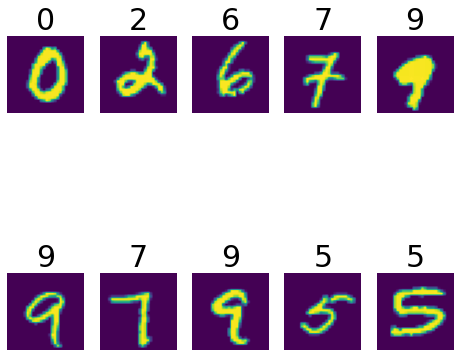

In [59]:
#plotting random predicted outputs
fig = plt.figure(figsize=(8,8))
for i in range (1,11):
  fig.add_subplot(2,5,i)
  plt.title(raw_svm_lbl[i-1], size= 30)
  plt.imshow(raw_svm_img[i-1])
  plt.axis('off')

plt.show()